<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>






<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/code_and_data/blob/main/Mining_GeoDFs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Mining your GeoDataFrame

This final session will need all the files from the zipped folder "miningGDF" available [here](https://drive.google.com/drive/folders/1aLZXirKg0AeEeY7CRpYCOjVgYv2Dj2Hx?usp=sharing). Download and unzip that folder, which has two folders (map and data).

First, let's open the _brazilMaps_5641.gpkg_ map file:

In [1]:
#en la evaluacion solo poner lo que se les pide
from  fiona import listlayers
import os

brazilMaps=os.path.join('maps','brazilMaps_5641.gpkg')

#layers in maps
listlayers(brazilMaps)

['border',
 'airports',
 'country',
 'cities',
 'rivers',
 'states',
 'municipalities']

In [2]:
# reading in the data:
import os
import geopandas as gpd

states=gpd.read_file(brazilMaps,layer='states')
municipalities=gpd.read_file(brazilMaps,layer='municipalities')
airports=gpd.read_file(brazilMaps,layer='airports')
rivers=gpd.read_file(brazilMaps,layer='rivers')
border=gpd.read_file(brazilMaps,layer='border')

Now, we are going to add more data. In this [link](https://msi.nga.mil/Publications/WPI) we find the  World Port Index (Pub 150), which contains several data on major ports and terminals world-wide. Read in the **UpdatedPub150.csv** file also from zipped folder:

In [3]:
import pandas as pd 


portsFile=os.path.join('data','UpdatedPub150.csv')

infoseaports=pd.read_csv(portsFile)
#columns available (so many)
infoseaports.columns.to_list()

['World Port Index Number',
 'Region Name',
 'Main Port Name',
 'Alternate Port Name',
 'UN/LOCODE',
 'Country Code',
 'World Water Body',
 'IHO S-130 Sea Area',
 'Sailing Direction or Publication',
 'Publication Link',
 'Standard Nautical Chart',
 'IHO S-57 Electronic Navigational Chart',
 'IHO S-101 Electronic Navigational Chart',
 'Digital Nautical Chart',
 'Tidal Range (m)',
 'Entrance Width (m)',
 'Channel Depth (m)',
 'Anchorage Depth (m)',
 'Cargo Pier Depth (m)',
 'Oil Terminal Depth (m)',
 'Liquified Natural Gas Terminal Depth (m)',
 'Maximum Vessel Length (m)',
 'Maximum Vessel Beam (m)',
 'Maximum Vessel Draft (m)',
 'Offshore Maximum Vessel Length (m)',
 'Offshore Maximum Vessel Beam (m)',
 'Offshore Maximum Vessel Draft (m)',
 'Harbor Size',
 'Harbor Type',
 'Harbor Use',
 'Shelter Afforded',
 'Entrance Restriction - Tide',
 'Entrance Restriction - Heavy Swell',
 'Entrance Restriction - Ice',
 'Entrance Restriction - Other',
 'Overhead Limits',
 'Underkeel Clearance Manage

Let's do some preprocessing:

In [4]:
#duda
#rename
infoseaports.rename(columns={'Main Port Name':'portName'},inplace=True)
#subset
infoseaports=infoseaports.loc[:,['portName', 'Country Code','Latitude', 'Longitude']]

# we have now
infoseaports.info()
#crs no proyectado 4326

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 0 to 3738
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3739 non-null   object 
 1   Country Code  3739 non-null   object 
 2   Latitude      3739 non-null   float64
 3   Longitude     3739 non-null   float64
dtypes: float64(2), object(2)
memory usage: 117.0+ KB


In [5]:
# some rows
infoseaports.head()

,portName,Country Code,Latitude,Longitude
0,Maurer,United States,40.533333,-74.250000
1,Mangkasa Oil Terminal,Indonesia,-2.733333,121.066667
2,Iharana,Madagascar,-13.350000,50.000000
3,Andoany,Madagascar,-13.400000,48.300000
4,Chake Chake,Tanzania,-5.250000,39.766667


It looks ready to become a spatial object (GDF of points):

In [6]:
#spatial points (unprojected)
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                           geometry=gpd.points_from_xy(infoseaports.Longitude,
                                                       infoseaports.Latitude), 
                          crs=4326)# notice it is unprojected

# subset:
seaports_bra=seaports[seaports['Country Code']=='Brazil'].copy()

# reset indexes
seaports_bra.reset_index(drop=True, inplace=True)

# reprojecting
seaports_bra_5641=seaports_bra.to_crs(5641) # projected crs

Let me plot seaports along with the airports (only large ones) we have:

<Axes: >

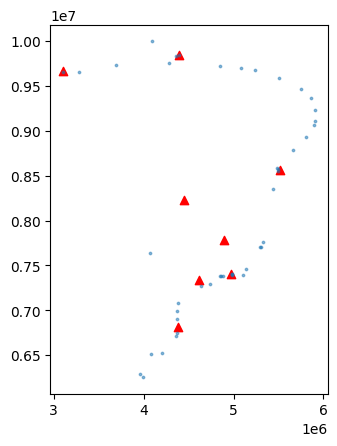

In [8]:
# subsetting
largeAirports=airports[airports['type']=='large_airport'] #can't use "airports.type"
largeAirports.reset_index(drop=True, inplace=True)

#plotting
base=largeAirports.plot(color='red',marker="^")
seaports_bra_5641.plot(ax=base,alpha=0.5,markersize=3)

# Part I. Distance between spatial objects

## Distance between points

The easiest way to understand distance is to compute how far two coordinates are from each other.

You have the seaports:

In [9]:
seaports_bra_5641.head()

,portName,Country Code,Latitude,Longitude,geometry
0,Dtse / Gegua Oil Terminal,Brazil,-22.816667,-43.150000,POINT (4983312.180 7408269.607)
1,Porto De Mucuripe,Brazil,-3.716667,-38.483333,POINT (5502488.831 9588988.711)
2,Portocel,Brazil,-19.850000,-40.050000,POINT (5328193.788 7760588.183)
3,Santa Clara,Brazil,-20.883333,-51.366667,POINT (4069190.463 7638681.573)
4,Aratu,Brazil,-12.783333,-38.500000,POINT (5500634.592 8575321.802)


..and the large airports:

In [10]:
largeAirports.head()

,name,type,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
0,Guarulhos - Governador André Franco Montoro In...,large_airport,-23.431944,-46.467778,2461.0,São Paulo,São Paulo,POINT (4614202.306 7334259.930)
1,Rio Galeão – Tom Jobim International Airport,large_airport,-22.809999,-43.250557,28.0,Rio de Janeiro,Rio De Janeiro,POINT (4972125.000 7409069.810)
2,Presidente Juscelino Kubitschek International ...,large_airport,-15.869167,-47.920834,3497.0,Distrito Federal,Brasília,POINT (4452546.729 8223176.558)
3,Deputado Luiz Eduardo Magalhães International ...,large_airport,-12.908611,-38.322498,64.0,Bahia,Salvador,POINT (5520382.068 8561117.560)
4,Tancredo Neves International Airport,large_airport,-19.635710,-43.966928,2721.0,Minas Gerais,Belo Horizonte,POINT (4892427.199 7785766.984)


If both GDFs have the same projected CRS, we can use the **distance** function. In this case, just two selected points:

In [11]:
# distance between 'Guarulhos' and 'Dtse / Gegua Oil Terminal' in km
largeAirports.iloc[0].geometry.distance(seaports_bra_5641.iloc[0].geometry)/1000
#geometry para saber la distancia de un punto a otro punto. la distancia sale en km

376.45654676312876

What about computing all possible distances between those GDFs?

In [12]:
#try 1: default
seaports_bra_5641.geometry.apply\
(lambda g: largeAirports.geometry.distance(g)/1000)
#a la columna geometrya aeropuestos la calcula toda entre mil

,0,1,2,3,4,5,6,7
0,376.456547,11.215763,972.514937,1271.810704,388.283851,2936.568258,845.014311,2510.234598
1,2423.397372,2243.508905,1722.736560,1028.026882,1903.623858,2400.478414,2992.287458,1141.403441
2,831.588609,500.350026,990.326096,823.276150,436.493404,2928.112036,1337.994526,2287.848785
3,624.267928,931.671799,698.996719,1719.547971,836.273186,2243.945536,881.830905,2232.167407
4,1525.121886,1280.416377,1105.664706,24.325363,996.650914,2633.078121,2086.128729,1688.319476
5,2293.987340,2046.008923,1769.194495,771.805485,1764.410446,2839.030154,2855.954845,1639.305541
6,639.170185,897.615004,1481.745011,2151.084932,1165.831878,3183.058035,71.677342,3103.880291
7,244.481056,121.176128,929.825791,1352.673407,403.398003,2874.224071,739.537460,2506.404649
8,2382.062554,2146.510809,1815.145260,870.955869,1851.717042,2781.274261,2947.244055,1555.463073
9,2410.208878,2193.956793,1791.587591,928.562523,1881.204203,2651.803098,2978.427871,1410.340738


In [13]:
# try 2: see names (change indexes)

seaports_bra_5641.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000)
#aqui se ordena con nombre de puertos

name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
portName,,,,,,,,
Dtse / Gegua Oil Terminal,376.456547,11.215763,972.514937,1271.810704,388.283851,2936.568258,845.014311,2510.234598
Porto De Mucuripe,2423.397372,2243.508905,1722.736560,1028.026882,1903.623858,2400.478414,2992.287458,1141.403441
Portocel,831.588609,500.350026,990.326096,823.276150,436.493404,2928.112036,1337.994526,2287.848785
Santa Clara,624.267928,931.671799,698.996719,1719.547971,836.273186,2243.945536,881.830905,2232.167407
Aratu,1525.121886,1280.416377,1105.664706,24.325363,996.650914,2633.078121,2086.128729,1688.319476
Cabedelo,2293.987340,2046.008923,1769.194495,771.805485,1764.410446,2839.030154,2855.954845,1639.305541
Imbituba,639.170185,897.615004,1481.745011,2151.084932,1165.831878,3183.058035,71.677342,3103.880291
Angra Dos Reis,244.481056,121.176128,929.825791,1352.673407,403.398003,2874.224071,739.537460,2506.404649
Natal,2382.062554,2146.510809,1815.145260,870.955869,1851.717042,2781.274261,2947.244055,1555.463073


In [14]:
#try 3: reorder previous output

seaports_bra_5641.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
#aqui se ordena alfabeticamente
#si pide calcular distancias esta opcion sera la mejor
#lo que quiere el profesor es que se entienda lo que pide 
#solo se muestra sin guardar

name,Deputado Luiz Eduardo Magalhães International Airport,Eduardo Gomes International Airport,Guarulhos - Governador André Franco Montoro International Airport,Hercílio Luz International Airport,Presidente Juscelino Kubitschek International Airport,Rio Galeão – Tom Jobim International Airport,Tancredo Neves International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
portName,,,,,,,,
Angra Dos Reis,1352.673407,2874.224071,244.481056,739.537460,929.825791,121.176128,403.398003,2506.404649
Aratu,24.325363,2633.078121,1525.121886,2086.128729,1105.664706,1280.416377,996.650914,1688.319476
Belem,1707.900996,1296.885238,2515.667230,3025.452935,1617.854012,2499.852237,2114.986138,8.253587
Cabedelo,771.805485,2839.030154,2293.987340,2855.954845,1769.194495,2046.008923,1764.410446,1639.305541
Cameta,1721.297005,1176.914817,2440.461226,2938.884991,1538.183094,2443.236436,2059.664194,149.134547
Camocim,1152.632398,2137.917034,2427.461207,2991.025682,1655.985765,2286.191573,1925.446175,866.757782
Dtse / Gegua Oil Terminal,1271.810704,2936.568258,376.456547,845.014311,972.514937,11.215763,388.283851,2510.234598
Gebig,1350.724987,2884.184234,254.627362,743.621948,938.275198,111.280352,406.474580,2512.417246
Guaiba Island Terminal,1337.414605,2893.527941,275.412013,760.011850,943.847471,90.553384,401.585110,2512.415474


Let's keep the last one:

In [15]:
distanceMatrixKM_sea_air= seaports_bra_5641.set_index('portName').geometry.apply\
                          (lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
                          sort_index(axis=0).sort_index(axis=1)
#aqui se guarda el resultado

This a data frame (pandas), and the names of the facilities are row and column indexes. This is useful this way:

In [16]:
# the mean distance from a seaport to all the large airports (sorted)
distanceMatrixKM_sea_air.mean(axis=1).sort_values(ascending=True) #axis=0?
#aqui se ve la distancia media, distancia promedio por cada fila

portName
Angra Dos Reis               1146.465071
Gebig                        1150.200738
Guaiba Island Terminal       1151.845981
Dtse / Gegua Oil Terminal    1164.012371
Rio De Janeiro               1168.190272
Niteroi                      1169.707707
Sao Sebastiao                1179.519797
Santos                       1186.176495
Macae                        1224.614645
Porto Do Forno               1238.729569
Vitoria                      1255.779907
Tubarao                      1260.952624
Portocel                     1266.998704
Santa Clara                  1271.087681
Port Of Ilheus               1344.159144
Paranagua                    1349.660596
Sao Francisco                1409.128772
Port De Salvador             1409.693480
Madre De Deus                1412.758466
Aratu                        1417.463196
Itajai                       1460.946843
Imbituba                     1586.757835
Port De Aracaju              1613.078902
Laguna                       1620.490194
Porto D

Let's compute more stats:

In [17]:
SomeStats=pd.DataFrame()
SomeStats['mean']=distanceMatrixKM_sea_air.mean(axis=1)
SomeStats['min']=distanceMatrixKM_sea_air.min(axis=1)
SomeStats['max']=distanceMatrixKM_sea_air.max(axis=1)

# see some
SomeStats.head(10)
#aqui se calcula la minima y la maxima ademas de la media

,mean,min,max
portName,,,
Angra Dos Reis,1146.465071,121.176128,2874.224071
Aratu,1417.463196,24.325363,2633.078121
Belem,1848.356547,8.253587,3025.452935
Cabedelo,1997.462154,771.805485,2855.954845
Cameta,1808.472039,149.134547,2938.884991
Camocim,1930.427202,866.757782,2991.025682
Dtse / Gegua Oil Terminal,1164.012371,11.215763,2936.568258
Gebig,1150.200738,111.280352,2884.184234
Guaiba Island Terminal,1151.845981,90.553384,2893.527941


We can also use **idxmax** to get the particular locations:

In [18]:
# farthest airport to each seaport
distanceMatrixKM_sea_air.idxmax(axis=1)
#la funcion idxmax te da el maximo 
#busca elk valor maximo y devuelve la cabecera

portName
Angra Dos Reis                             Eduardo Gomes International Airport
Aratu                                      Eduardo Gomes International Airport
Belem                                       Hercílio Luz International Airport
Cabedelo                                    Hercílio Luz International Airport
Cameta                                      Hercílio Luz International Airport
Camocim                                     Hercílio Luz International Airport
Dtse / Gegua Oil Terminal                  Eduardo Gomes International Airport
Gebig                                      Eduardo Gomes International Airport
Guaiba Island Terminal                     Eduardo Gomes International Airport
Guamare Oil Terminal                        Hercílio Luz International Airport
Imbituba                                   Eduardo Gomes International Airport
Itacoatiara                                 Hercílio Luz International Airport
Itajai                                     

In [19]:
# farthest seaport to each airport
distanceMatrixKM_sea_air.idxmax(axis=0)

name
Deputado Luiz Eduardo Magalhães International Airport                   Rio Grande
Eduardo Gomes International Airport                                     Rio Grande
Guarulhos - Governador André Franco Montoro International Airport           Manaus
Hercílio Luz International Airport                                   Porto Santana
Presidente Juscelino Kubitschek International Airport                   Rio Grande
Rio Galeão – Tom Jobim International Airport                                Manaus
Tancredo Neves International Airport                                        Manaus
Val de Cans/Júlio Cezar Ribeiro International Airport                   Rio Grande
dtype: object

In [20]:
# closest airport to each seaport
distanceMatrixKM_sea_air.idxmin(axis=1)

portName
Angra Dos Reis                    Rio Galeão – Tom Jobim International Airport
Aratu                        Deputado Luiz Eduardo Magalhães International ...
Belem                        Val de Cans/Júlio Cezar Ribeiro International ...
Cabedelo                     Deputado Luiz Eduardo Magalhães International ...
Cameta                       Val de Cans/Júlio Cezar Ribeiro International ...
Camocim                      Val de Cans/Júlio Cezar Ribeiro International ...
Dtse / Gegua Oil Terminal         Rio Galeão – Tom Jobim International Airport
Gebig                             Rio Galeão – Tom Jobim International Airport
Guaiba Island Terminal            Rio Galeão – Tom Jobim International Airport
Guamare Oil Terminal         Deputado Luiz Eduardo Magalhães International ...
Imbituba                                    Hercílio Luz International Airport
Itacoatiara                                Eduardo Gomes International Airport
Itajai                                     

In [21]:
# closest seaport to each airport
distanceMatrixKM_sea_air.idxmin(axis=0)

name
Deputado Luiz Eduardo Magalhães International Airport                         Port De Salvador
Eduardo Gomes International Airport                                                     Manaus
Guarulhos - Governador André Franco Montoro International Airport                       Santos
Hercílio Luz International Airport                                                    Imbituba
Presidente Juscelino Kubitschek International Airport                              Santa Clara
Rio Galeão – Tom Jobim International Airport                         Dtse / Gegua Oil Terminal
Tancredo Neves International Airport                                 Dtse / Gegua Oil Terminal
Val de Cans/Júlio Cezar Ribeiro International Airport                                    Belem
dtype: object

### Exercises Part I

<div class="alert-warning">
    
Exercises 1,2,3,4 for this part must read you data from GitHub links, and the coding and results must be published using GitHub Pages

</div>

### Exercise 1

<div class="alert-success">
    
1. Use two maps of points.

2. Compute the distance matrix for both maps.

3. Select one row of the distance matrix, and plot the two points with the minimal distance on top of the country of your choosing.
</div>

In [ ]:
#hacer en un repo aparte

## Distance between line and point

Let's take a look at the rivers we have:

In [ ]:
rivers

In [ ]:
#keep one:

rivers[rivers.NAME.str.contains('Grande')]

You can see that distance works between these two elements:

In [ ]:
# distance from each airport to Rio Grande
rivers[rivers.NAME.str.contains('Grande')].iloc[0].geometry.distance(largeAirports.set_index('name').geometry)/1000

Based on what we did previously, let's compute all the distances:

In [ ]:
distanceMatrixKM_riv_air=rivers.set_index('NAME').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
distanceMatrixKM_riv_air

Here, we see one row (river), that tells the distance to each column (large airport):

In [ ]:
distanceMatrixKM_riv_air.loc['Rio Grande, South America'].sort_values()

Let's try a simple plot of the river and the airports:

In [ ]:
base=largeAirports.explore(color='red',marker_kwds=dict(radius=10))
rivers[rivers.NAME.str.contains('Grande')].explore(m=base)

Now, let's focus on the rivers that belong to a system:

In [ ]:
rivers[~rivers.SYSTEM.isna()]

Let's dissolve the ones that belong to a system into a multiline:

In [ ]:
systems=rivers.dissolve(by='SYSTEM')
systems

Let's do some basic formatting:

In [ ]:
# format the GDF:

systems.reset_index(drop=False,inplace=True)
systems.drop(columns='NAME',inplace=True)

# we have
systems

Another distance matrix:

In [ ]:
distanceMatrixKM_sys_air=systems.set_index('SYSTEM').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sys_air

This time, let me get all the minimum distances:

In [ ]:
mins=distanceMatrixKM_sys_air.idxmin(axis="columns") # same as axis=1
mins

In [ ]:
# one of them
mins.iloc[1]

Let's see now:

In [ ]:
base=systems.explore()
# the closest
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
# NOT the closest
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))


### Exercise 2

<div class="alert-success">
    
1. Use a map of points and a map of lines.

2. Compute the distance matrix for both maps.

3. Select one line of the distance matrix, and plot the closests and the farthest point to that line.
    
    
</div>

## Polygon to point

Let me create some **convex hull**s (polygons):

In [ ]:
# polygon for each system
systems.convex_hull

In [ ]:
# see them
systems.convex_hull.plot()

Now, a GDF for the hulls:

In [ ]:
systems_hulls=systems.convex_hull.to_frame()
systems_hulls['system']=['Amazon', 'Parana']
systems_hulls.rename(columns={0:'geometry'},inplace=True)
systems_hulls=systems_hulls.set_geometry('geometry')
systems_hulls.crs="EPSG:5641"
systems_hulls

Next, the distance matrix:

In [ ]:

distanceMatrixKM_sysHull_air=systems_hulls.set_index('system').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sysHull_air

All the minimal differences:

In [ ]:
mins=distanceMatrixKM_sysHull_air.idxmin(axis="columns")
mins

In [ ]:
# plotting
base=systems_hulls.explore()
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

### Exercise 3

<div class="alert-success">
    
1. Create a set of points and a set of polygons

2. Compute the distance matrix for both sets.

3. Select one polygon of the distance matrix, and plot the closests and the farthest point to that polygon.
    
</div>    

## Distances using _Buffers_

A very important case in distance analysis is the use of buffers:

In [ ]:
# remember:
distanceMatrixKM_riv_air

In [ ]:
# getting a value (it can be any value)
distanceMatrixKM_riv_air.loc['Amazon'].min()

We can use any value to create a buffer:

In [ ]:
minMts=distanceMatrixKM_riv_air.loc['Amazon'].min()*1000

#the buffer is a polygon:
rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)

In [ ]:
# see buffer:
bufferAroundAmazon=rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})

Above we used the buffer (red polygon), and the river (blue). Let me add a layer of airports (small ones):

In [ ]:
small_airports=airports[airports['type']=='small_airport']

# plotting
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
small_airports.explore(m=bufferAsBase,color='black')

Now, we can use the buffer (polygon) to keep the airports that are at that particular distance around the river:

In [ ]:

riversWithinBuffer=small_airports.clip(mask=bufferAroundAmazon)
#
riversWithinBuffer

In [ ]:
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
riversWithinBuffer.explore(m=bufferAsBase,color='black')

In [ ]:
# minimum of all the minimum by row
distanceMatrixKM_riv_air.min(axis=1).min() 

In [ ]:
# using the previous value
minMinMts_5=5*distanceMatrixKM_riv_air.min(axis=1).min()*1000


allMinBuffer=rivers.buffer(distance = minMinMts_5).explore(color='red')
rivers.explore(m=allMinBuffer,color='blue',style_kwds={'weight':0.5})

In [ ]:
# you see all the buffer polygons:
riversAll_buf=rivers.buffer(distance = minMinMts_5)
riversAll_buf

Now keep small airports in buffer:

In [ ]:
allRiversWithinBuffs=small_airports.clip(riversAll_buf)
allRiversWithinBuffs

In [ ]:
# simple
base=riversAll_buf.plot(color='yellow')
allRiversWithinBuffs.plot(ax=base, color='green', markersize=1)

In [ ]:
# folium

base=riversAll_buf.explore(color='yellow')
allRiversWithinBuffs.explore(m=base, color='green')

### Exercise 4

<div class="alert-success">
    
1. Create a set of points and a set of lines

2. Get the buffer for the lines, select different values for the distance.

3. Keep the points that are within the buffer (as in point 2, you need to play with differn distances until you show something interesting.  
    
</div>   

# Using data from spatial objects

This is time to use  *dataPeru_indicadores.xlsx* file and the  map of Peruvian districts: *DistritosMap.zip* (zipped shape file).

Let's read the data in :

In [ ]:
# data table
import pandas as pd

peruData=os.path.join("data","dataPeru_indicadores.xlsx")
datadis=pd.read_excel(peruData,
                     dtype={'Ubigeo': object})
datadis.info()

In [ ]:
# map
import geopandas as gpd

peruDataDist=os.path.join("maps","DistritosMap.zip")

datadismap=gpd.read_file(peruDataDist)

datadismap.info()

Next we will merge the indicators table into the map.

## Merging

When merging, verify the amount of resulting rows first:

In [ ]:
datadismap.merge(datadis, left_on='DISTRITO', right_on='Distrito').shape

That is totally wrong. Let's check:

In [ ]:
datadis.Distrito

In [ ]:
datadismap.DISTRITO

The amount of rows is the same when separate, but increases when merged. 

Let's do some preprocessing:

In [ ]:
# all capitals, no empty spaces before or after.

capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

The names from non-english speaking countries may come with some symbols that may cause trouble (', ~). Let's get rid of those:

In [ ]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].map(byePunctuation)  #applymap for olderpandas
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].map(byePunctuation) #applymap for olderpandas

Are the name of the districts unique?

In [ ]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

The presence of duplicates, forces we create  a column of unique values:

In [ ]:
# concatenating
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [ ]:
# the new column looks like this:
datadis['provDist'].head()

It would be good making sure no *ghost* appears between words:

In [ ]:
# replacing dashes and multiple spaces by a simple space
datadis['provDist']=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap['provDist']=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

Let's find out what is NOT matched between the  tables:

In [ ]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

This is what could not be matched:

In [ ]:
len(nomatch_df), len(nomatch_gdf)

Let's try renaming the districts using **fuzzy merging**:

In [ ]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

If you are comfortable, you prepare a _dictionary_ of changes:

In [ ]:
# is this OK?
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

In [ ]:
# then:
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

Now, make the replacements:

In [ ]:
datadis.provDist.replace(changesDis_df,inplace=True)

Now the merge can happen:

In [ ]:
datadisMap=datadismap.merge(datadis, on='provDist')
# check
datadisMap.info()

In [ ]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO','provDist']
datadisMap.drop(columns=bye,inplace=True)

# keeping
datadisMap.head()

### Exercises Part II

<div class="alert-warning">
    
Exercises 5,6,7,8, and 9 for this part must read you data from GitHub links, and the coding and results must be published using GitHub Pages. This is a different project, so those exercises will be published in a different webpage.

</div>

### Exercise 5

<div class="alert-success">
    
1. Get a polygons map of the lowest administrative unit possible.
    
2. Get a table of variables for those units. At least 3 numerical variables.

3. Preprocess both tables and get them ready for merging.

4. Do the merging, making the changes needed so that you keep the most columns.
    
    
</div>

## Exploring one variable

This time, we explore statistically one variable in the map:

In [ ]:
# statistics
datadisMap.IDH2019.describe()

In [ ]:
import seaborn as sea

sea.histplot(datadisMap.IDH2019, color='yellow')

Notice the histogram divides the data in intervals which are the base of the bars. Seaborn uses the [Freedman-Diaconis](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) formula to compute the bins.

Let's see other possibilities, but please install [**numba**](https://numba.readthedocs.io/en/stable/user/installing.html) before runing the next code; also make sure you have **pysal**, **mapclassify** and **numpy** installed: 

In [ ]:
import mapclassify 
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=datadisMap['IDH2019']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)   

How can we select the right classification?

Let me use the the **absolute deviation around class median** (ADCM) to make the comparisson:

In [ ]:
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['Classifier'] = [c.name for c in class5]

# see the value
adcms

In [ ]:
# rename
adcms.rename(columns = {0:'ADCM'},inplace=True)

# reorder and plot
adcms=adcms.sort_values('ADCM').reset_index()
sea.barplot(y='Classifier',
    hue='Classifier', x='ADCM', data=adcms, palette='Pastel1'
);

Let's keep the the scheme with the lowest  ADCM:

In [ ]:
datadisMap['IDH_jc5'] = jc5.yb

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
datadisMap.plot(column='IDH_jc5', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Notice the **geopandas.plot()** can also use those schemes:

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadisMap.plot(column='IDH2019', 
        cmap='viridis',       
        scheme='JenksCaspall',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Notice some details on the result:

In [ ]:
# we got
jc5

In [ ]:
# group label
np.unique(jc5.yb,return_counts=True)

In [ ]:
# jc5.yb into a pandas Series

pd.Series(jc5.yb).value_counts()

In [ ]:
# these are the cuts, but it is not including the min value
jc5.bins

In [ ]:
# completing the bins
jc5_bins=list(jc5.bins)
jc5_bins.insert(0,datadisMap.IDH2019.min())

In [ ]:
sea.histplot(datadisMap.IDH2019, bins=jc5_bins,color='yellow')

### Exercise 6

<div class="alert-success">
    
1. Choose a numeric variable from your merged data.
2. Decide which is the  best classification scheme for that variable.
3. Make a map for the best scheme.
4. Make a histogram for the best scheme.
</div>

## Neighborhood

We can compute the neighborhood for each object in a map using different algorithms:

In [ ]:
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(datadisMap,use_index=False) 

In [ ]:
# queen
w_queen = Queen.from_dataframe(datadisMap,use_index=False)

In [ ]:
# k nearest neighbors
w_knn = KNN.from_dataframe(datadisMap, k=4)

Let's understand the differences:

In [ ]:
# first district in the GDF:
datadisMap.head(1)

In [ ]:
# amount of neighbors of that district
len(w_rook.neighbors[0])

In [ ]:
# details
datadisMap.iloc[w_rook.neighbors[0],]

In [ ]:
# see the neighbor
datadisMap.iloc[w_rook.neighbors[0] ,].plot(facecolor="yellow")

In [ ]:
# see whole area
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="yellow",edgecolor='k')
datadisMap.head(1).plot(ax=base,facecolor="red")

Let's do the same with queen neighbors:

In [ ]:
# how many
len(w_queen.neighbors[0])

In [ ]:
# details
datadisMap.iloc[w_queen.neighbors[0] ,]

In [ ]:
# see
datadisMap.iloc[w_queen.neighbors[0] ,].plot(facecolor="yellow")

In [ ]:
# whole area
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow",edgecolor='k')
datadisMap.head(1).plot(ax=base,facecolor="red")

In [ ]:
w_knn.neighbors[0]

In [ ]:
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_knn.neighbors[0],].plot(ax=base,facecolor="yellow")
datadisMap.head(1).plot(ax=base,facecolor="red")

### Exercise 7

<div class="alert-success">
        
Compute the neighbors of the capital of your country. Plot the results for each of the options.
    
</div>

## Spatial correlation

We need the neighboorhood matrix (the weight matrix) to compute spatial correlation: if the variable value is correlated with the values of its neighbors - which proves a spatial effect.

In [ ]:
pd.DataFrame(*w_knn.full()) # 1 means both are neighbors

In [ ]:
# needed for spatial correlation
w_knn.transform = 'R'

In [ ]:
pd.DataFrame(*w_knn.full()).head(12) # 1 means both are neighbors

Spatial correlation is measured by the Moran's I statistic:

In [ ]:
from esda.moran import Moran

moranIDH = Moran(datadisMap['IDH2019'], w_knn)
moranIDH.I,moranIDH.p_sim

A significant Moran's I suggest spatial correlation. Let's see the spatial scatter plot

In [ ]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std');

### Exercise 8

<div class="alert-success">
    
1. Compute the Moran's coefficient for **all** your numeric variables.
    
2. Make a scatter plot for each variable.
    
</div>

### Local Spatial Correlation

We can compute a LISA (local Moran) for each case. That will help us find spatial clusters (spots) and spatial outliers:

* A **hotSpot** is a polygon whose value in the variable is high AND is surrounded with polygons with also high values.

* A **coldSpot** is a polygon whose value in the variable is low AND is surrounded with polygons with also low values.

* A **coldOutlier** is a polygon whose value in the variable is low BUT is surrounded with polygons with  high values.

* A **hotOutlier** is a polygon whose value in the variable is high BUT is surrounded with polygons with  low values.

It is also possible that no significant correlation is detected. Let's see those values:

In [ ]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=datadisMap['IDH2019'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std');
#plt.show()

In [ ]:
# the map with the spots and outliers
import matplotlib.pyplot as plt

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   datadisMap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)});
plt.show()

Let me add that data to my gdf:

In [ ]:
# quadrant
lisaIDH.q

In [ ]:
# significance
lisaIDH.p_sim

In [ ]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

The info in **lisaIDH.q** can not be used right away, we need to add if the local spatial correlation is significant:

In [ ]:
datadisMap['IDH_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
datadisMap['IDH_quadrant'].value_counts()

Now, we recode:

In [ ]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

datadisMap['IDH_quadrant_names']=[labels[i] for i in datadisMap['IDH_quadrant']]

datadisMap['IDH_quadrant_names'].value_counts()

In [ ]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'white', 'pink', 'cyan', 'azure','red'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

datadisMap.plot(column='IDH_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='k',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### Exercise 9

<div class="alert-success">
    
1. Compute the Local Moran for the variables in your data that have significant spatial correlation.
    
2. Create a new column for each of those variables, with a label ('0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier').

3. Prepare a map for each of the variables analyzed, showing the spots and outliers.
    
</div>